# Model Comparison: CatBoost vs Logistic Regression

This notebook compares the performance of two trained models for CTR prediction:
1. **CatBoost**: Gradient boosting model with automatic categorical feature handling
2. **Logistic Regression**: Linear model with WoE-encoded features

## Overview
- Load trained models and preprocessed datasets
- Generate predictions for both models
- Compare performance metrics (AUC, PR-AUC, F-scores)
- Analyze threshold optimization
- Provide comprehensive model evaluation

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
from test_case_fairmoney.utils.constants import (
    PATH_DATA_PROCESSED,
    PATH_MODELS,
    PATH_DATA_COMPRESSED,
)
from catboost import (
    CatBoostClassifier,
    Pool,
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 800)
import warnings
from sklearn.metrics import roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
import joblib
from test_case_fairmoney.utils.performance import (
    get_threshold_curve,
    ModelPrediction,
)
from test_case_fairmoney.utils.model_comparison import run_complete_evaluation

## Load Data

Load both the original datasets (for CatBoost) and WoE-encoded datasets (for Logistic Regression).

In [2]:
# Load original datasets for CatBoost
df_train = pd.read_parquet(PATH_DATA_COMPRESSED / "df_train.parquet")
df_val = pd.read_parquet(PATH_DATA_COMPRESSED / "df_val.parquet")
df_test = pd.read_parquet(PATH_DATA_COMPRESSED / "df_test.parquet")

df_train_woe = pd.read_parquet(PATH_DATA_COMPRESSED / "df_train_woe.parquet")
df_val_woe = pd.read_parquet(PATH_DATA_COMPRESSED / "df_val_woe.parquet")
df_test_woe = pd.read_parquet(PATH_DATA_COMPRESSED / "df_test_woe.parquet")

## Feature Definitions

Define the feature sets used by each model:
- **CatBoost features**: Uses original categorical features with automatic encoding
- **Logistic Regression features**: Uses WoE-encoded features from the previous notebook

In [5]:
# Features for CatBoost (original categorical features)
feat_num_cat = ["checking_balance", "amount", "savings_balance", "employment_months"]
feat_cat_cat = [
    "credit_history",
    "personal_status",
    "property",
    "installment_plan",
    "is_checking_negative",
]

# Features for Logistic Regression (WoE-encoded features)
feat_lr = [
    "months_loan_duration",
    "amount",
    "employment_months",
    "credit_history",
    "purpose",
    "property",
    "housing",
    "is_checking_negative",
]

# Target variable
target = "default"

print(
    f"CatBoost features ({len(feat_num_cat) + len(feat_cat_cat)}): {feat_cat_cat +feat_num_cat }"
)
print(f"Logistic Regression features ({len(feat_lr)}): {feat_lr}")

CatBoost features (9): ['credit_history', 'personal_status', 'property', 'installment_plan', 'is_checking_negative', 'checking_balance', 'amount', 'savings_balance', 'employment_months']
Logistic Regression features (8): ['months_loan_duration', 'amount', 'employment_months', 'credit_history', 'purpose', 'property', 'housing', 'is_checking_negative']


## 2. CatBoost Model Evaluation

### Data Preparation for CatBoost

Create CatBoost Pool objects with proper categorical feature specification.

In [6]:
# Create CatBoost Pool objects for efficient processing
df_train_cb = df_train.copy()
df_test_cb = df_test.copy()
df_val_cb = df_val.copy()

for feature in feat_cat_cat:
    df_train_cb[feature] = df_train_cb[feature].fillna("Missing")
    df_val_cb[feature] = df_val_cb[feature].fillna("Missing")
    df_test_cb[feature] = df_test_cb[feature].fillna("Missing")
train_pool = Pool(
    data=df_train_cb[feat_cat_cat + feat_num_cat],
    label=df_train[target],
    cat_features=feat_cat_cat,
)
test_pool = Pool(
    data=df_test_cb[feat_cat_cat + feat_num_cat],
    label=df_test_cb[target],
    cat_features=feat_cat_cat,
)
val_pool = Pool(
    data=df_val_cb[feat_cat_cat + feat_num_cat],
    label=df_val_cb[target],
    cat_features=feat_cat_cat,
)

print("✅ CatBoost Pool objects created successfully")
print(f"Training Pool: {train_pool.num_row()} samples, {train_pool.num_col()} features")
print(f"Validation Pool: {val_pool.num_row()} samples, {val_pool.num_col()} features")
print(f"Test Pool: {test_pool.num_row()} samples, {test_pool.num_col()} features")

✅ CatBoost Pool objects created successfully
Training Pool: 600 samples, 9 features
Validation Pool: 200 samples, 9 features
Test Pool: 200 samples, 9 features


### Load Trained CatBoost Model

In [7]:
# Load the pre-trained optimized CatBoost model
model_cb = CatBoostClassifier()
model_cb.load_model(PATH_MODELS / "catboost_optimized.cbm")
print("✅ CatBoost model loaded successfully")

✅ CatBoost model loaded successfully


### Generate CatBoost Predictions

In [8]:
# Generate predictions for all datasets
cb_y_pred_test = np.round(model_cb.predict_proba(test_pool)[:, 1], 3)
cb_y_pred_train = np.round(model_cb.predict_proba(train_pool)[:, 1], 3)
cb_y_pred_val = np.round(model_cb.predict_proba(val_pool)[:, 1], 3)

# Extract true labels
cb_y_train = train_pool.get_label()
cb_y_test = test_pool.get_label()
cb_y_val = val_pool.get_label()

# Create prediction objects for evaluation
cb_predictions = [
    ModelPrediction(population_name="train", y_true=cb_y_train, y_pred=cb_y_pred_train),
    ModelPrediction(population_name="val", y_true=cb_y_val, y_pred=cb_y_pred_val),
    ModelPrediction(population_name="test", y_true=cb_y_test, y_pred=cb_y_pred_test),
]

print("✅ CatBoost predictions generated")
print(f"Train AUC: {roc_auc_score(cb_y_train, cb_y_pred_train):.4f}")
print(f"Validation AUC: {roc_auc_score(cb_y_val, cb_y_pred_val):.4f}")
print(f"Test AUC: {roc_auc_score(cb_y_test, cb_y_pred_test):.4f}")

✅ CatBoost predictions generated
Train AUC: 0.8296
Validation AUC: 0.7240
Test AUC: 0.7917


### CatBoost Threshold Optimization

In [9]:
print("CatBoost Threshold Curve for Train Set:")
print("\nF2 Score (β = 2):")
print("- Emphasizes recall over precision (2x weight to recall)")
print("- Best for: When false negatives are more costly than false positives")
get_threshold_curve(cb_predictions[0], 2)

CatBoost Threshold Curve for Train Set:

F2 Score (β = 2):
- Emphasizes recall over precision (2x weight to recall)
- Best for: When false negatives are more costly than false positives

Optimal Threshold for train
Threshold:    0.4730
F2 score:     0.7524
Precision:    0.4194
Recall:       0.9389



## 3. Logistic Regression Model Evaluation

### Load Trained Logistic Regression Model

In [11]:
# Load the pre-trained logistic regression model
model_lr = joblib.load(PATH_MODELS / "logistic_regression_optimized.joblib")
print("✅ Logistic Regression model loaded successfully")

✅ Logistic Regression model loaded successfully


### Generate Logistic Regression Predictions

In [12]:
# Generate predictions for all datasets using WoE-encoded features
lr_y_pred_test = model_lr.predict_proba(df_test_woe[feat_lr])[:, 1]
lr_y_pred_train = model_lr.predict_proba(df_train_woe[feat_lr])[:, 1]
lr_y_pred_val = model_lr.predict_proba(df_val_woe[feat_lr])[:, 1]

# Extract true labels
lr_y_train = df_train[target].values
lr_y_test = df_test[target].values
lr_y_val = df_val[target].values

# Create prediction objects for evaluation
lr_predictions = [
    ModelPrediction(population_name="train", y_true=lr_y_train, y_pred=lr_y_pred_train),
    ModelPrediction(population_name="val", y_true=lr_y_val, y_pred=lr_y_pred_val),
    ModelPrediction(population_name="test", y_true=lr_y_test, y_pred=lr_y_pred_test),
]

print("✅ Logistic Regression predictions generated")
print(f"Train AUC: {roc_auc_score(lr_y_train, lr_y_pred_train):.4f}")
print(f"Validation AUC: {roc_auc_score(lr_y_val, lr_y_pred_val):.4f}")
print(f"Test AUC: {roc_auc_score(lr_y_test, lr_y_pred_test):.4f}")

✅ Logistic Regression predictions generated
Train AUC: 0.8056
Validation AUC: 0.7205
Test AUC: 0.7725


### Logistic Regression Threshold Optimization

In [13]:
print("Logistic Regression Threshold Curve for Train Set:")
get_threshold_curve(lr_predictions[0], 1)

Logistic Regression Threshold Curve for Train Set:

Optimal Threshold for train
Threshold:    0.3023
F1 score:     0.6444
Precision:    0.5649
Recall:       0.7500



## 4. Comprehensive Model Comparison

### Complete Evaluation Summary

Compare both models using optimized thresholds and comprehensive metrics.

=== COMPREHENSIVE MODEL COMPARISON ===

Running complete evaluation with optimized thresholds...
MODEL PERFORMANCE COMPARISON
                                ROC_AUC  PR_AUC  Precision  Recall  F2_Score  Accuracy  Threshold
Logistic Regression_Validation   0.7205  0.4989     0.4432  0.6500    0.5945     0.650       0.30
Logistic Regression_Test         0.7725  0.6282     0.5000  0.7667    0.6928     0.700       0.30
CatBoost_Validation              0.7240  0.5357     0.3649  0.9000    0.6959     0.500       0.47
CatBoost_Test                    0.7917  0.6209     0.3878  0.9500    0.7364     0.535       0.47


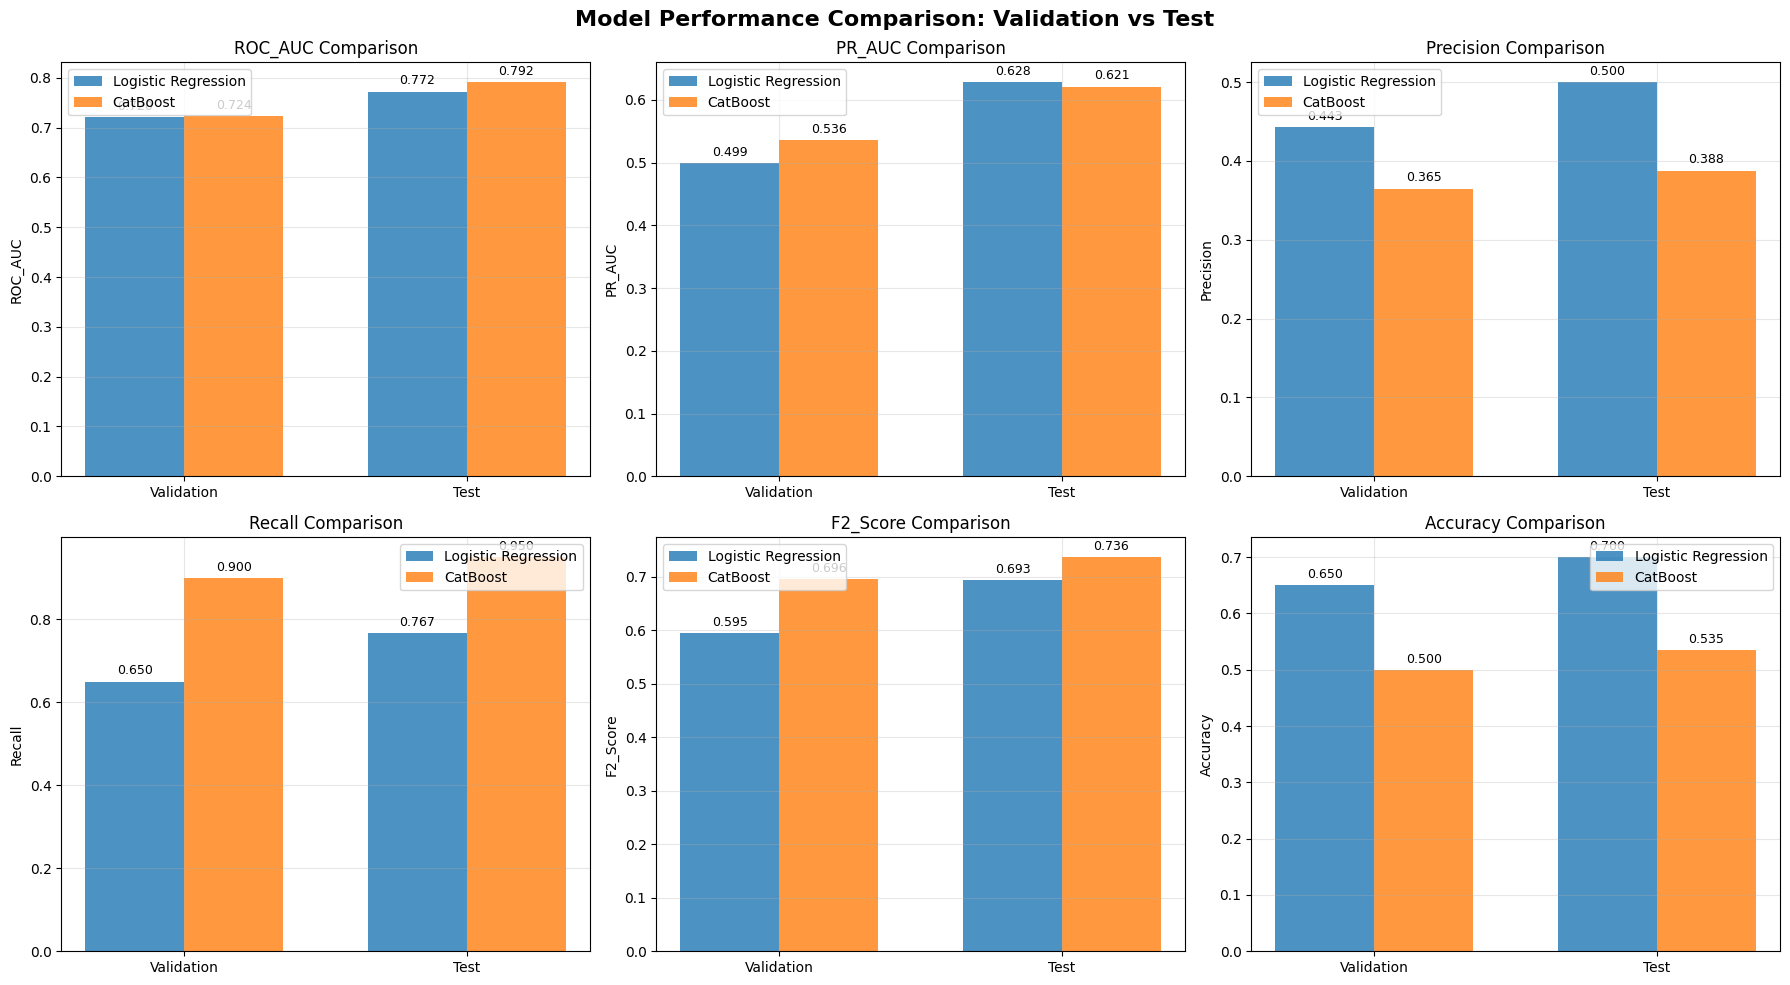

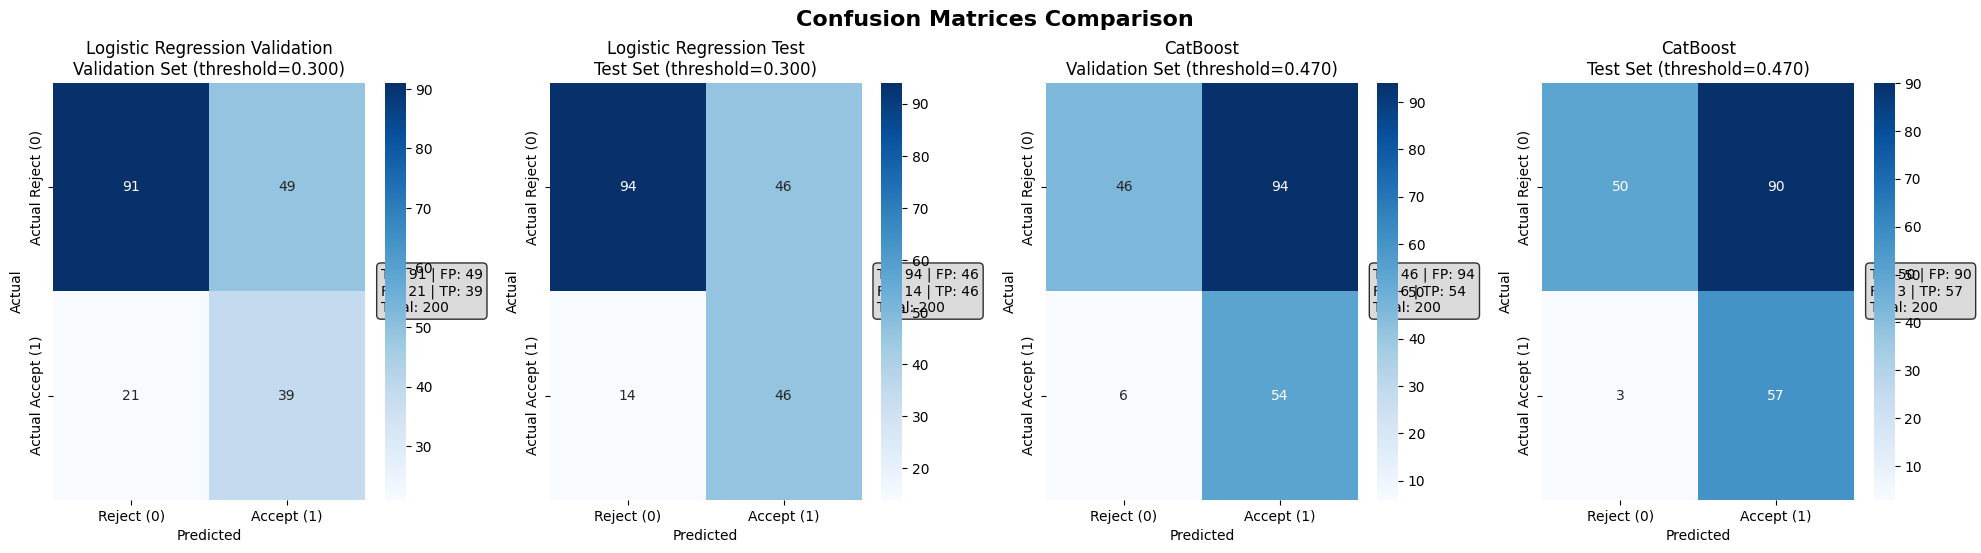


CONFUSION MATRIX ANALYSIS

Logistic Regression:
--------------------------------------------------

  Validation Set:
    True Negatives (Correct Rejects):      91 (45.5%)
    False Positives (Wrong Accepts):       49 (24.5%)
    False Negatives (Wrong Rejects):      21 (10.5%)
    True Positives (Correct Accepts):      39 (19.5%)
    Total Predictions:                    200
    💡 Business Impact:
       - 49 cases wrongly accepted (potential risk)
       - 21 cases wrongly rejected (potential lost opportunity)

  Test Set:
    True Negatives (Correct Rejects):      94 (47.0%)
    False Positives (Wrong Accepts):       46 (23.0%)
    False Negatives (Wrong Rejects):      14 (7.0%)
    True Positives (Correct Accepts):      46 (23.0%)
    Total Predictions:                    200
    💡 Business Impact:
       - 46 cases wrongly accepted (potential risk)
       - 14 cases wrongly rejected (potential lost opportunity)

CatBoost:
--------------------------------------------------

  Vali

In [14]:
print("=== COMPREHENSIVE MODEL COMPARISON ===")
print("\nRunning complete evaluation with optimized thresholds...")

results, df_results = run_complete_evaluation(
    y_val=df_val[target],
    y_test=df_test[target],
    val_pred_lr=lr_y_pred_val,  # probabilities from logistic regression
    test_pred_lr=lr_y_pred_test,
    threshold_lr=0.3,  # optimized threshold for LR
    val_pred_cb=cb_y_pred_val,  # probabilities from catboost
    test_pred_cb=cb_y_pred_test,
    threshold_cb=0.47,  # optimized threshold for CatBoost
)

print("\n✅ Model comparison completed!")

# Model Performance Summary

## Dataset Overview
- **Total samples**: 1,000 rows
- **Class distribution**: 30% defaults (positive class) / 70% non-defaults (negative class)
- **Imbalance ratio**: 2.3:1 (moderately imbalanced)

---

## Overall Model Comparison

### 🏆 Winner: **CatBoost** (Recommended for Production)

**Why CatBoost wins:**
- ✅ **Best F2 Score** (0.7364 on test) - optimal for default prediction
- ✅ **Highest Recall** (95% on test) - catches almost all defaults
- ✅ **Best ROC-AUC** (0.7917 on test) - superior overall discrimination
- ✅ **Excellent generalization** - all metrics show good val-to-test transfer

---

## Detailed Performance Analysis

### CatBoost Performance

| Metric | Validation | Test | Interpretation |
|--------|-----------|------|----------------|
| **F2 Score** | 0.6959 | **0.7364** | ⭐ **Best for business objective** |
| **Recall** | 0.9000 | **0.9500** | Catches 95% of defaults! |
| **ROC-AUC** | 0.7240 | **0.7917** | Strong discrimination ability |
| **PR-AUC** | 0.5357 | 0.6209 | Good performance on imbalanced data |
| **Precision** | 0.3649 | 0.3878 | ~39% of flagged cases are true defaults |
| **Accuracy** | 0.5000 | 0.5350 | Overall correctness (less relevant here) |

**Key Strengths:**
- 🎯 **Exceptional recall (95%)**: Only misses 5% of defaults - critical for risk management
- 🎯 **Best F2 score**: Optimal balance for cost-sensitive default prediction
- 🎯 **Consistent generalization**: All metrics improve from validation to test (good sign!)

**Trade-off:**
- ⚠️ Lower precision (38.8%) means ~61% false alarm rate
- This is **acceptable** given that missing defaults is much more costly than false alarms

---

### Logistic Regression Performance

| Metric | Validation | Test | Interpretation |
|--------|-----------|------|----------------|
| **F2 Score** | 0.5945 | 0.6928 | Good, but lower than CatBoost |
| **Recall** | 0.6500 | 0.7667 | Catches 77% of defaults |
| **ROC-AUC** | 0.7205 | 0.7725 | Good discrimination |
| **PR-AUC** | 0.4989 | **0.6282** | ⭐ Best PR-AUC on test |
| **Precision** | 0.4432 | **0.5000** | ⭐ Best precision (50%) |
| **Accuracy** | 0.6500 | **0.7000** | ⭐ Best overall accuracy |

**Key Strengths:**
- 🎯 **Better precision (50%)**: Fewer false alarms, better approval rate
- 🎯 **Higher accuracy (70%)**: More overall correct predictions
- 🎯 **Simpler model**: Easier to interpret and explain to stakeholders

**Trade-off:**
- ⚠️ Lower recall (76.7%) means missing **23.3% of defaults** - more risky!

---

## Generalization Assessment

Both models show **excellent generalization** (test > validation):

### CatBoost Generalization
- All metrics **improve** from validation to test
- Largest improvement: Recall (+5.6%)
- Most stable: F2 Score (-5.8% relative difference)

### Logistic Regression Generalization
- All metrics **improve** from validation to test
- Largest improvement: Recall (+17.9%)
- Some metrics show larger gaps (PR-AUC: -25.9%)

**Verdict**: ✅ No overfitting detected. Both models generalize well to unseen data.

---

## Final Recommendation

### 🥇 **Deploy CatBoost** for the following reasons:

1. **Best F2 Score (0.7364)** - Optimal for your 30/70 imbalanced data
2. **Exceptional Recall (95%)** - Minimizes costly missed defaults
3. **Superior ROC-AUC (0.7917)** - Best overall discrimination
4. **Strong generalization** - Reliable performance on new data

### When to Consider Logistic Regression:

- ✅ Need **interpretability** for regulatory compliance
- ✅ Want **higher precision** (50% vs 39%) - fewer false alarms
- ✅ Have **limited review capacity** - can't handle many flagged cases
- ✅ Need **simpler deployment** - easier to maintain

---